##### Importacion de librerias

In [8]:
import time
from matplotlib import pyplot as plt
import seaborn as sns
import numpy as np
sns.set_style("whitegrid")
plt.rcParams["figure.figsize"] = (5,5)

# Ejercicio 1

#### Periodo

In [9]:
print(2**64)

18446744073709551616


#### Generador

In [10]:
class XORShiftGenerator:

  PERIOD = (2**64) 
 
  def __init__(self,external_seed):
    self.seed = external_seed % self.PERIOD

  def random(self):
    seed_tuple = (23,13,58)
    self.seed = (self.seed ^ (self.seed << seed_tuple[0])) % self.PERIOD
    self.seed = (self.seed ^ (self.seed >> seed_tuple[1])) % self.PERIOD
    self.seed = (self.seed ^ (self.seed << seed_tuple[2])) % self.PERIOD
    return self.seed
    
  def u_random(self):
    return self.random() / self.PERIOD

In [11]:
generator = XORShiftGenerator(int(time.time()))

generated = []
uniform_generated = []
for i in range(1000):
    generated.append(generator.random())
    uniform_generated.append(generator.u_random())

#### Generamos 1000 valores usando el generador

In [12]:
class GCL: #Generador ejercicio 6
    # datos provistos
    m = 2**32
    a = 1013904223
    c = 1664525
    
    def __init__(self,seed):
        self.xn = seed
        
    def random(self):
        self.xn = (self.c + self.xn*self.a) % self.m
        return self.xn

    def u_random(self):
        return self.random() / self.m

In [5]:
gcl_generator = GCL(int((99289 + 96453 + 100853 + 97839 )/4)) # parte entera del promedio de los padrones

gcl_generated = []
gcl_uniform_generated = []
for i in range(1000):
    gcl_generated.append(gcl_generator.random())
    gcl_uniform_generated.append(gcl_generator.u_random())

#### Y estudiamos los resultados

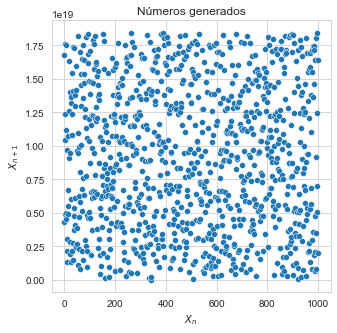

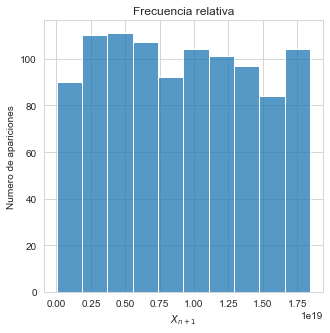

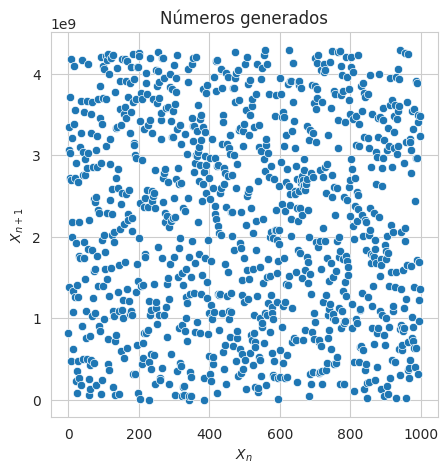

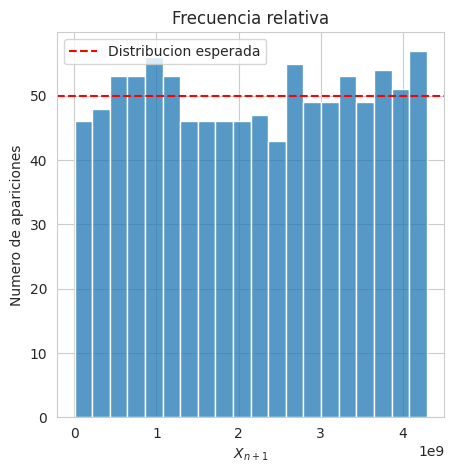

In [11]:
sns.scatterplot(data=generated)
plt.title('Números generados')
plt.ylabel("$X_{n+1}$")
plt.xlabel("$X_n$")
plt.show()

sns.histplot(data=generated,bins=20)
plt.axhline(
    y=1000 / 20,
    xmin=0,
    xmax=1,
    color="r",
    linestyle="--",
    label="Distribucion esperada",
)
plt.title('Frecuencia relativa')
plt.ylabel("Numero de apariciones")
plt.xlabel("$X_{n+1}$")
plt.legend()
plt.show()

sns.scatterplot(data=gcl_generated)
plt.title('Números generados')
plt.ylabel("$X_{n+1}$")
plt.xlabel("$X_n$")
plt.show()

sns.histplot(data=gcl_generated,bins=20)
plt.title('Frecuencia relativa')
plt.ylabel("Numero de apariciones")
plt.xlabel("$X_{n+1}$")
plt.axhline(
    y=1000 / 20,
    xmin=0,
    xmax=1,
    color="r",
    linestyle="--",
    label="Distribucion esperada",
)
plt.legend()
plt.show()

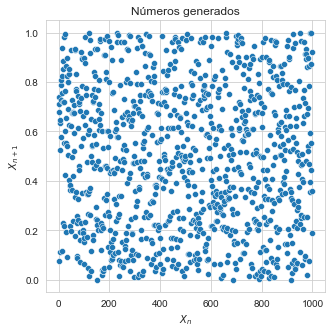

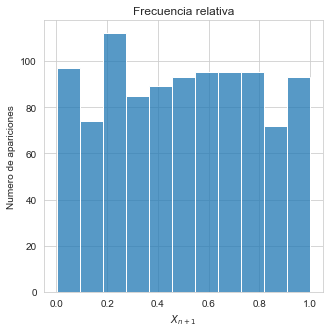

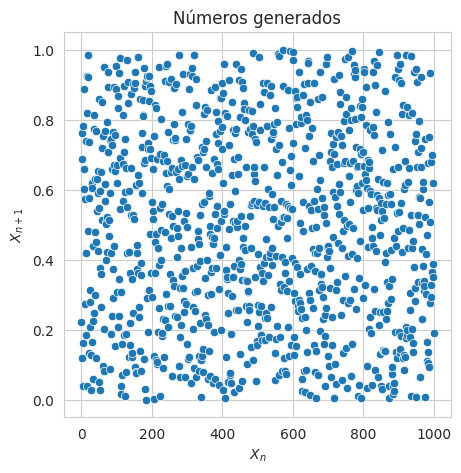

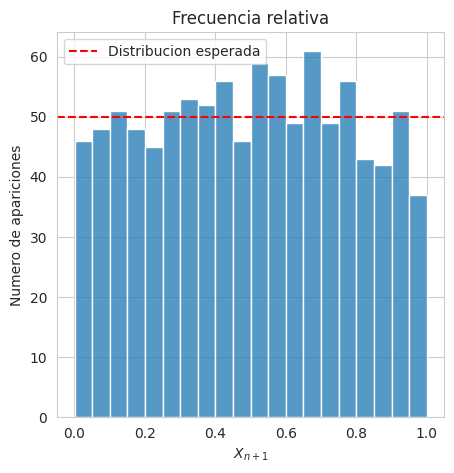

In [12]:
sns.scatterplot(data=uniform_generated)
plt.title('Números generados')
plt.ylabel("$X_{n+1}$")
plt.xlabel("$X_n$")
plt.show()

sns.histplot(data=uniform_generated,bins=20)
plt.title('Frecuencia relativa')
plt.ylabel("Numero de apariciones")
plt.xlabel("$X_{n+1}$")
plt.axhline(
    y=1000 / 20,
    xmin=0,
    xmax=1,
    color="r",
    linestyle="--",
    label="Distribucion esperada",
)
plt.legend()
plt.show()

sns.scatterplot(data=gcl_uniform_generated)
plt.title('Números generados')
plt.ylabel("$X_{n+1}$")
plt.xlabel("$X_n$")
plt.show()

sns.histplot(data=gcl_uniform_generated,bins=20)
plt.axhline(
    y=1000 / 20,
    xmin=0,
    xmax=1,
    color="r",
    linestyle="--",
    label="Distribucion esperada",
)
plt.title('Frecuencia relativa')
plt.ylabel("Numero de apariciones")
plt.xlabel("$X_{n+1}$")
plt.legend()
plt.show()

# EJERCICIO 2

### Test de Kolmogorov

In [8]:
from scipy.stats import kstest

generator = XORShiftGenerator(int(time.time()))

def generate_sample(longitud):
    sample = []
    for i in range(longitud):
      sample.append(generator.u_random())
    return sample

def kol_test_sample(sample):
    tested = kstest(sample, 'uniform')
    if tested[1] >= 0.05:
        print("El test acepta la hipotesis nula.")
    else:
        print("El test rechaza la hipótesis nula")
    print("Estadistico: {:.4f} ".format(tested[0]))
    print("P Valor: {:.4f} ".format(tested[1]))

In [9]:
big_sample = generate_sample(10000)
kol_test_sample(big_sample)

El test acepta la hipotesis nula.
Estadistico: 0.0106 
P Valor: 0.2074 


In [10]:
small_sample = generate_sample(1000)
kol_test_sample(small_sample)

El test acepta la hipotesis nula.
Estadistico: 0.0252 
P Valor: 0.5392 


In [11]:
def gcl_generate_sample(longitud):
    sample = []
    for i in range(longitud):
      sample.append(gcl_generator.u_random())
    return sample

In [12]:
gcl_big_sample = gcl_generate_sample(10000)
kol_test_sample(gcl_big_sample)

El test rechaza la hipótesis nula
Estadistico: 0.0175 
P Valor: 0.0043 


In [13]:
gcl_small_sample = gcl_generate_sample(1000)
kol_test_sample(gcl_small_sample)

El test acepta la hipotesis nula.
Estadistico: 0.0239 
P Valor: 0.6092 


### Test 2

### Test 3

# EJERCICIO 3

In [14]:
# genexp genera un valor de una variable Exp(lam) utilizando equivalencia de eventos contra una uniforme (0,1)
# ver: pag.4 de https://campusgrado.fi.uba.ar/pluginfile.php/29915/mod_page/content/419/Te%C3%B3rica%204%20Generaci%C3%B3n%20de%20variables%20continuas%20y%20discretas.pdf
def genexp(u, lam=1):
    return -np.log(1-u) / lam

def normalpdf(x, mu=0, sigma=1):
    var = np.square(sigma)
    return np.exp(-np.square(x - mu) / (2 * var)) / np.sqrt(2 * np.pi * var)
def exppdf(x, lam=1):
    return lam * np.exp(-lam * x)

# gennorm genera valores de una normal de media "mu" y desviación "sigma", utilizando un metodo de aceptación rechazo contra una variable Exp(1)
# ver: pag.9 de https://campusgrado.fi.uba.ar/pluginfile.php/29915/mod_page/content/419/Te%C3%B3rica%204%20Generaci%C3%B3n%20de%20variables%20continuas%20y%20discretas.pdf
def gennorm(N, mu=0, sigma=1):
    c = np.sqrt(2 * np.e / np.pi)
    t = np.array([genexp(generator.u_random()) for _ in range(N)])

    # probabilidad de aceptar
    p = normalpdf(t) / (c * exppdf(t))

    z = np.array([])
    for i in range(N):
        if generator.u_random() < p[i]:
            r2 = generator.u_random()
            val = t[i] if r2 < 0.5 else -t[i]
            z = np.concatenate((z, [sigma * val + mu]))

    return z

[Text(0.5, 0, 'Nros pseudoaleatorios'), Text(0, 0.5, 'Frecuencia')]

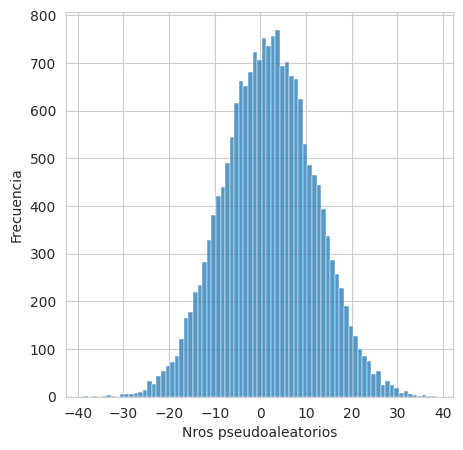

In [15]:
# Generamos una muestra de N=10000 y graficamos el histograma
N=50000

mu = 2.0
sigma = 10.0

data = gennorm(N, mu, sigma)
sns.histplot(data=data).set(xlabel="Nros pseudoaleatorios",ylabel="Frecuencia")

## Tests Estadísticos

In [16]:
from scipy.stats import kstest, shapiro, norm

def cdf(x):
    return norm.cdf(x, loc=mu, scale=sigma)

alfa = 0.05

### Test 1: Kolmogorov-Smirnov

In [17]:
K, pv = kstest(data, cdf)

print("K = %f, p-val = %f" % (K, pv))
print("Existe evidencia para rechazar que los datos no siguen una distribución normal (2,10)" if pv < alfa else "No existe evidencia para afirmar que los datos no se distribuyen de forma normal (2, 10)")

K = 0.006161, p-val = 0.463222
No existe evidencia para afirmar que los datos no se distribuyen de forma normal (2, 10)


### Test 2: Shapiro-Wilk

In [18]:
sorted_data = np.sort(data)

S, pv = shapiro(sorted_data)

print("S = %f, p-val = %f" % (S, pv))
print("Existe evidencia para rechazar que los datos no siguen una distribución normal (2,10)" if pv < alfa else "No existe evidencia para afirmar que los datos no se distribuyen de forma normal (2, 10)")

S = 0.999886, p-val = 0.524123
No existe evidencia para afirmar que los datos no se distribuyen de forma normal (2, 10)


/home/mpicco/.local/lib/python3.10/site-packages/scipy/stats/_morestats.py:1800: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")
